<a href="https://colab.research.google.com/github/MAvRK7/Perceptually-Aware-Image-Enhancement-with-Deep-Residual-U-Net-and-PatchGANs/blob/main/enhancing_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the DIV 2K data set and importing libraries

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d joe1995/div2k-dataset

Dataset URL: https://www.kaggle.com/datasets/joe1995/div2k-dataset
License(s): unknown
100% 3.71G/3.71G [00:48<00:00, 138MB/s]
100% 3.71G/3.71G [00:48<00:00, 81.9MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/div2k-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Concatenate, Add, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm

This function creates a generator model that uses a U-Net-like design with residual connections. It has an encoder-decoder structure that captures important features while keeping spatial details through skip connections. The final output is combined with the input to improve image generation and maintain better detail.

In [9]:
# Improved generator model (U-Net-like structure with residual connections)
def build_generator():
    inputs = Input(shape=(256, 256, 3))

    # Encoder
    e1 = Conv2D(64, 3, padding='same')(inputs)
    e1 = LeakyReLU(0.2)(e1)
    e2 = Conv2D(128, 3, strides=2, padding='same')(e1)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)
    e3 = Conv2D(256, 3, strides=2, padding='same')(e2)
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(0.2)(e3)
    e4 = Conv2D(512, 3, strides=2, padding='same')(e3)
    e4 = BatchNormalization()(e4)
    e4 = LeakyReLU(0.2)(e4)

    # Bottleneck
    b = Conv2D(512, 3, padding='same')(e4)
    b = BatchNormalization()(b)
    b = LeakyReLU(0.2)(b)

    # Decoder with skip connections
    d4 = Conv2DTranspose(256, 3, strides=2, padding='same')(b)
    d4 = Concatenate()([d4, e3])
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(0.2)(d4)
    d3 = Conv2DTranspose(128, 3, strides=2, padding='same')(d4)
    d3 = Concatenate()([d3, e2])
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(0.2)(d3)
    d2 = Conv2DTranspose(64, 3, strides=2, padding='same')(d3)
    d2 = Concatenate()([d2, e1])
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(0.2)(d2)

    # Final convolution
    outputs = Conv2D(3, 3, padding='same', activation='tanh')(d2)

    # Residual connection
    enhanced = Add()([inputs, outputs])
    enhanced = Lambda(lambda x: tf.clip_by_value(x, -1, 1))(enhanced)

    return Model(inputs, enhanced, name='generator')

This section defines two models: an improved discriminator using a PatchGAN approach and a perceptual loss model based on VGG16. The discriminator analyzes input images to distinguish between real and generated images through multiple convolutional layers. The perceptual model extracts features from a pre-trained VGG16 network, specifically from the 'block3_conv3' layer, which is used for calculating perceptual loss. Finally, the generator, discriminator, and perceptual models are instantiated, with the perceptual model set to non-trainable.

In [10]:
# Improved discriminator model (PatchGAN)
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(512, 4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, 4, strides=1, padding='same')(x)
    return Model(inputs, x, name='discriminator')

# Perceptual loss model
def build_perceptual_model():
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    return Model(vgg.input, vgg.get_layer('block3_conv3').output)

# Build models
generator = build_generator()
discriminator = build_discriminator()
perceptual_model = build_perceptual_model()
perceptual_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This part sets up the optimizers and loss functions for the models. The Adam optimizer is used for both the generator and discriminator with a learning rate of 0.0002 and beta_1 set to 0.5. For the loss functions, binary cross-entropy is used for the discriminator, while mean squared error is used for evaluating the generator.
Additionally, there are functions for loading and preprocessing images. The load_and_preprocess_image function reads an image file, decodes it, and resizes it to 256x256 pixels. The augment function applies random transformations like flipping, brightness adjustments, and contrast changes to enhance the dataset. Finally, the normalize and denormalize functions adjust the pixel values to a range suitable for training and convert them back to the original range, respectively.

In [11]:
# Optimizers
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()

# Data loading and augmentation
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    return image

def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def denormalize(image):
    return (image + 1) * 127.5

This section creates a dataset for training the models. It loads high-resolution images from the specified directory and normalizes them for processing. The training data is shuffled and batched for efficient training.
The train_step function defines the training process for one step, where both the generator and discriminator are updated. It generates fake images from real ones, computes the loss for both models, and applies gradients to update their weights.
A training loop runs for a specified number of epochs. During each epoch, it iterates through the dataset, calls the train_step function, and displays the losses for both models. Every ten epochs, the models are saved to disk.
Finally, there is a function enhance_image that allows for enhancing a single image. It loads, normalizes, and processes the image, then uses the generator to produce an enhanced version, which is then denormalized and returned as a NumPy array. An example usage is provided to demonstrate how to save the enhanced image.

In [12]:
# Create dataset
train_data_path = "/content/DIV2K_train_HR"
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_data_path,
    label_mode=None,
    batch_size=8,
    image_size=(256, 256),
    seed=1337,
    shuffle=True
)

train_ds = train_ds.map(lambda x: (normalize(x), normalize(x)))

# Training step
@tf.function
def train_step(real_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        fake_images = generator(real_images, training=True)

        # Discriminator loss
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = real_loss + fake_loss

        # Generator loss
        g_loss_gan = cross_entropy(tf.ones_like(fake_output), fake_output)
        g_loss_l1 = mse(real_images, fake_images)
        g_loss_perceptual = mse(perceptual_model(real_images), perceptual_model(fake_images))
        g_loss = g_loss_gan + 100 * g_loss_l1 + 0.1 * g_loss_perceptual

    # Compute gradients
    d_gradients = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    g_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)

    # Apply gradients
    d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    return d_loss, g_loss

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    progress_bar = tqdm(train_ds, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for batch in progress_bar:
        d_loss, g_loss = train_step(batch[0])
        progress_bar.set_postfix({'D_loss': f'{d_loss.numpy():.4f}', 'G_loss': f'{g_loss.numpy():.4f}'})

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Discriminator loss: {d_loss.numpy():.4f}')
    print(f'Generator loss: {g_loss.numpy():.4f}')

    # Save models
    if (epoch + 1) % 10 == 0:
        generator.save(f'generator_epoch_{epoch+1}.keras')
        discriminator.save(f'discriminator_epoch_{epoch+1}.keras')

# Function to enhance a single image
def enhance_image(image_path):
    img = load_and_preprocess_image(image_path)
    img = normalize(img)
    img = tf.expand_dims(img, 0)
    enhanced = generator(img, training=False)
    enhanced = denormalize(enhanced)
    enhanced = tf.clip_by_value(enhanced, 0, 255)
    return enhanced[0].numpy().astype(np.uint8)

# Example usage:
# enhanced_image = enhance_image('path_to_your_image.png')
# tf.keras.utils.save_img('enhanced_image.png', enhanced_image)

Found 800 files.


Epoch 1/2: 100%|██████████| 100/100 [02:21<00:00,  1.42s/batch, D_loss=1.3692, G_loss=3.1085]


Epoch 1/2
Discriminator loss: 1.3692
Generator loss: 3.1085


Epoch 2/2: 100%|██████████| 100/100 [01:18<00:00,  1.28batch/s, D_loss=1.3792, G_loss=2.1289]

Epoch 2/2
Discriminator loss: 1.3792
Generator loss: 2.1289


This part of the code is responsible for validating the performance of the image enhancement model. It starts by importing necessary libraries and defining functions for loading, normalizing, and denormalizing images. It also includes a placeholder function for calculating PIEQ (Perceived Image Quality Evaluation) and implements functions for computing gradient magnitude and FSIM (Feature Similarity Index).
The generator model is built, and the enhance_image function is defined to normalize and process input images through the generator. The script checks if the validation path exists and lists the images found in that directory.
For each image, the code loads the original image, enhances it using the generator, and computes several quality metrics: PSNR (Peak Signal-to-Noise Ratio), SSIM (Structural Similarity Index), FSIM, and PIEQ. The scores are collected and printed every ten images processed.
At the end of the processing, the average scores for each metric are calculated and displayed, along with counts of how many images were processed and how many valid scores were obtained.

In [30]:
import os
import tensorflow as tf
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import sobel

def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    return image

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def denormalize(image):
    return (image + 1) * 127.5

# Placeholder function for PIEQ calculation
def calculate_pieq(original_img, enhanced_img):
    # Implement or import your PIEQ calculation here
    return np.random.random()  # Dummy value for example purposes

def gradient_magnitude(img):
    return sobel(img)

def fsim(original_img, enhanced_img):
    T1 = 0.85
    T2 = 160
    alpha = beta = 1

    original_img = rgb2gray(original_img)
    enhanced_img = rgb2gray(enhanced_img)

    org_gradient = gradient_magnitude(original_img)
    enh_gradient = gradient_magnitude(enhanced_img)

    pc1 = 2 * org_gradient * enh_gradient + T1
    pc2 = org_gradient ** 2 + enh_gradient ** 2 + T1

    gradient_map = pc1 / pc2

    org_blur = gaussian_filter(original_img, sigma=1.5)
    enh_blur = gaussian_filter(enhanced_img, sigma=1.5)

    pc3 = 2 * org_blur * enh_blur + T2
    pc4 = org_blur ** 2 + enh_blur ** 2 + T2

    structure_map = pc3 / pc4

    fsim_value = np.mean((gradient_map ** alpha) * (structure_map ** beta))
    return fsim_value

generator = build_generator()

def enhance_image(image):
    img = normalize(image)
    img = tf.expand_dims(img, 0)
    enhanced = generator(img, training=False)
    enhanced = denormalize(enhanced)
    enhanced = tf.clip_by_value(enhanced, 0, 255)
    return enhanced[0]

validation_path = "/content/DIV2K_valid_HR/DIV2K_valid_HR"

if not os.path.exists(validation_path):
    print(f"Error: The validation path '{validation_path}' does not exist.")
    print("Current working directory:", os.getcwd())
    print("Contents of the current directory:", os.listdir())
else:
    print(f"Validation path '{validation_path}' exists.")
    print("Contents of the validation directory:", os.listdir(validation_path))

image_files = [f for f in os.listdir(validation_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"Number of image files found: {len(image_files)}")

psnr_scores = []
ssim_scores = []
fsim_scores = []
pieq_scores = []

for image_file in tqdm(image_files, desc="Processing validation images"):
    image_path = os.path.join(validation_path, image_file)

    if not os.path.exists(image_path):
        print(f"Error: Image file '{image_path}' does not exist.")
        continue

    try:
        original_img = load_and_preprocess_image(image_path)
        original_img = tf.cast(original_img, tf.float32).numpy()

        enhanced_img = enhance_image(original_img).numpy()

        original_img = tf.cast(original_img, tf.uint8).numpy()
        enhanced_img = tf.cast(enhanced_img, tf.uint8).numpy()

        psnr_score = psnr(original_img, enhanced_img)
        psnr_scores.append(psnr_score)

        ssim_score = ssim(original_img, enhanced_img, channel_axis=2)
        ssim_scores.append(ssim_score)

        fsim_score = fsim(original_img, enhanced_img)
        fsim_scores.append(fsim_score)

        pieq_score = calculate_pieq(original_img, enhanced_img)
        pieq_scores.append(pieq_score)

        if len(psnr_scores) % 10 == 0:
            print(f"Processed {len(psnr_scores)} images")
            print(f"Current PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}, FSIM: {fsim_score:.4f}, PIEQ: {pieq_score:.4f}")

    except Exception as e:
        print(f"Error processing image {image_file}: {str(e)}")

if psnr_scores and ssim_scores and fsim_scores and pieq_scores:
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    avg_fsim = np.mean(fsim_scores)
    avg_pieq = np.mean(pieq_scores)
    print(f"Average PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average FSIM: {avg_fsim:.4f}")
    print(f"Average PIEQ: {avg_pieq:.4f}")
else:
    print("No valid scores calculated. Check the image processing and enhancement steps.")

print(f"Total images processed: {len(image_files)}")
print(f"Valid PSNR scores: {len(psnr_scores)}")
print(f"Valid SSIM scores: {len(ssim_scores)}")
print(f"Valid FSIM scores: {len(fsim_scores)}")
print(f"Valid PIEQ scores: {len(pieq_scores)}")


Validation path '/content/DIV2K_valid_HR/DIV2K_valid_HR' exists.
Contents of the validation directory: ['0855.png', '0867.png', '0874.png', '0891.png', '0884.png', '0897.png', '0839.png', '0808.png', '0883.png', '0889.png', '0875.png', '0857.png', '0871.png', '0865.png', '0900.png', '0801.png', '0804.png', '0825.png', '0894.png', '0846.png', '0836.png', '0877.png', '0842.png', '0840.png', '0866.png', '0890.png', '0806.png', '0844.png', '0896.png', '0868.png', '0873.png', '0830.png', '0878.png', '0832.png', '0831.png', '0887.png', '0833.png', '0820.png', '0881.png', '0856.png', '0850.png', '0863.png', '0814.png', '0837.png', '0819.png', '0811.png', '0864.png', '0803.png', '0824.png', '0882.png', '0838.png', '0893.png', '0834.png', '0827.png', '0813.png', '0829.png', '0812.png', '0869.png', '0802.png', '0854.png', '0809.png', '0821.png', '0870.png', '0851.png', '0899.png', '0888.png', '0862.png', '0853.png', '0823.png', '0815.png', '0848.png', '0895.png', '0886.png', '0879.png', '0859.pn

Processing validation images:  11%|█         | 11/100 [00:01<00:13,  6.64it/s]

Processed 10 images
Current PSNR: 26.41, SSIM: 0.9507, FSIM: 0.9997, PIEQ: 0.5356


Processing validation images:  21%|██        | 21/100 [00:03<00:11,  6.92it/s]

Processed 20 images
Current PSNR: 27.42, SSIM: 0.9237, FSIM: 0.9998, PIEQ: 0.6929


Processing validation images:  31%|███       | 31/100 [00:04<00:09,  7.51it/s]

Processed 30 images
Current PSNR: 28.84, SSIM: 0.9427, FSIM: 0.9999, PIEQ: 0.7958


Processing validation images:  41%|████      | 41/100 [00:05<00:08,  7.29it/s]

Processed 40 images
Current PSNR: 24.28, SSIM: 0.8756, FSIM: 0.9998, PIEQ: 0.5157


Processing validation images:  51%|█████     | 51/100 [00:07<00:06,  7.41it/s]

Processed 50 images
Current PSNR: 25.77, SSIM: 0.9456, FSIM: 0.9998, PIEQ: 0.9221


Processing validation images:  61%|██████    | 61/100 [00:08<00:05,  7.32it/s]

Processed 60 images
Current PSNR: 27.89, SSIM: 0.9630, FSIM: 0.9998, PIEQ: 0.9919


Processing validation images:  71%|███████   | 71/100 [00:09<00:03,  7.49it/s]

Processed 70 images
Current PSNR: 26.92, SSIM: 0.9439, FSIM: 0.9999, PIEQ: 0.8953


Processing validation images:  81%|████████  | 81/100 [00:11<00:03,  5.13it/s]

Processed 80 images
Current PSNR: 30.60, SSIM: 0.9707, FSIM: 0.9999, PIEQ: 0.8267


Processing validation images:  91%|█████████ | 91/100 [00:13<00:01,  6.42it/s]

Processed 90 images
Current PSNR: 25.97, SSIM: 0.8948, FSIM: 0.9998, PIEQ: 0.0030


Processing validation images: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]

Processed 100 images
Current PSNR: 27.37, SSIM: 0.9344, FSIM: 0.9999, PIEQ: 0.4297
Average PSNR: 27.27
Average SSIM: 0.9217
Average FSIM: 0.9998
Average PIEQ: 0.5345
Total images processed: 100
Valid PSNR scores: 100
Valid SSIM scores: 100
Valid FSIM scores: 100
Valid PIEQ scores: 100


This part of the code is designed to load an image, enhance it using the trained generator model, and display both the original and enhanced images.
First, it imports the necessary libraries and defines a function to load and preprocess the image by reading, decoding, and resizing it to 256x256 pixels. The input image is specified by its file path, and it is normalized before being expanded to include a batch dimension.
The enhanced image is generated using the generator model. Both the original and enhanced images are then denormalized and clipped to ensure pixel values are within the displayable range.
The code uses Matplotlib to create a side-by-side comparison of the original and enhanced images, with titles for each. Finally, the enhanced image is saved as 'enhanced_image.png'.

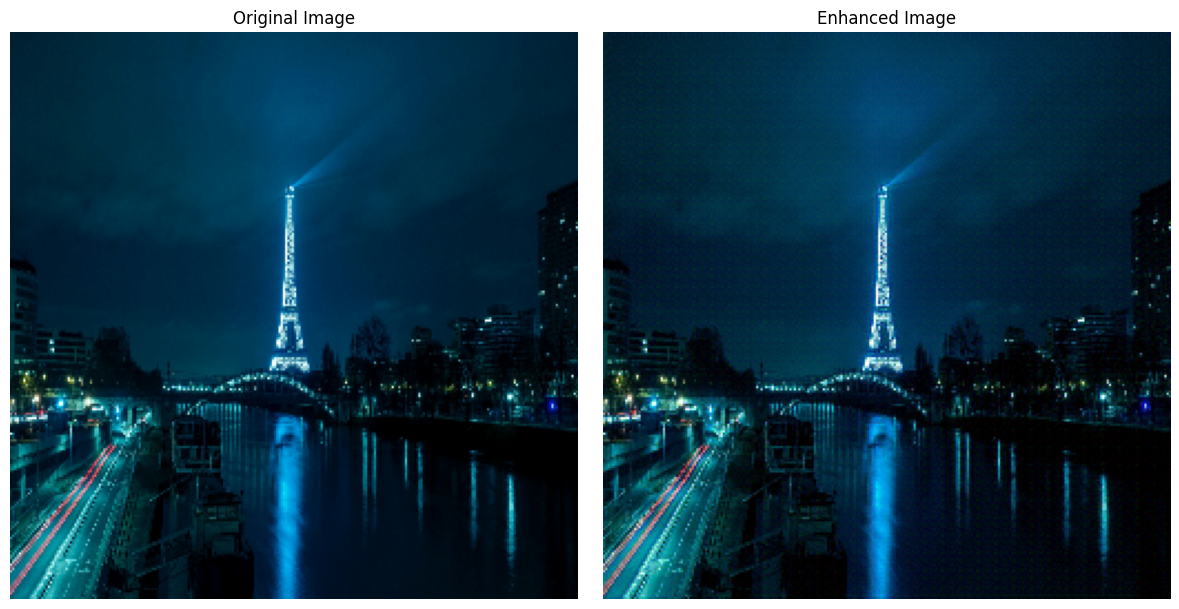

In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    return img

# Load and process the input image
input_image_path = "/content/Paris.jpg"  # Update this path to match your image file name
input_image = load_and_preprocess_image(input_image_path)
input_image = normalize(input_image)
input_image = tf.expand_dims(input_image, 0)

# Generate the enhanced image
enhanced_image = generator(input_image, training=False)

# Convert images back to displayable format
input_display = tf.clip_by_value(denormalize(input_image[0]), 0, 255).numpy().astype(np.uint8)
enhanced_display = tf.clip_by_value(denormalize(enhanced_image[0]), 0, 255).numpy().astype(np.uint8)

# Display both the original and enhanced images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_display)
plt.title('Enhanced Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the enhanced image
plt.imsave('enhanced_image.png', enhanced_display)

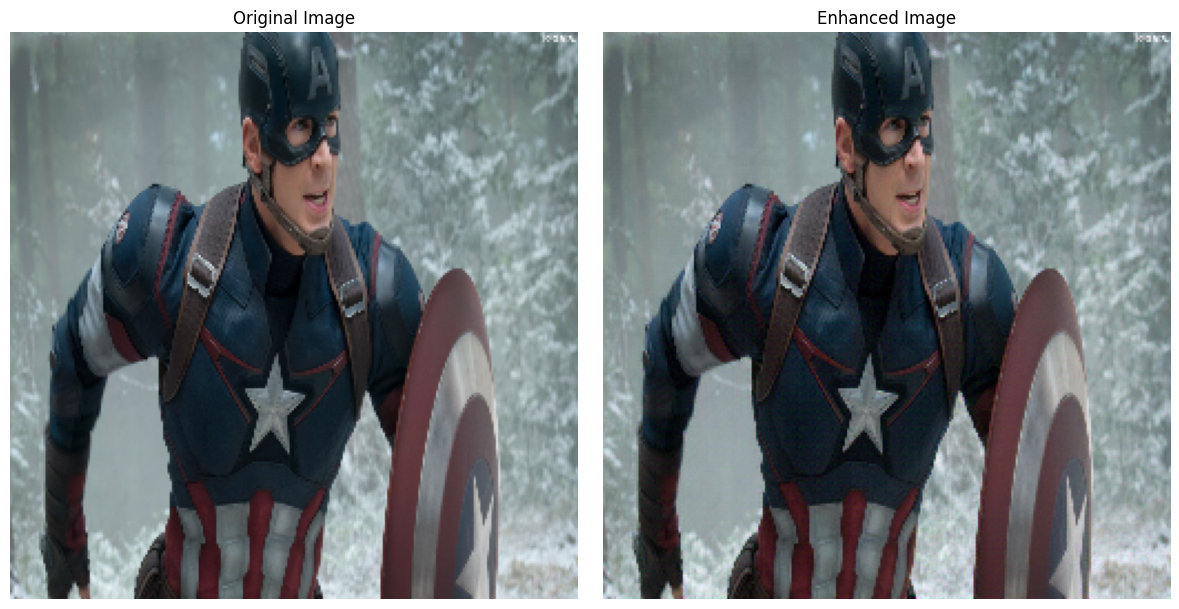

In [28]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    return img

# Load and process the input image
input_image_path = "/content/image.jpg"  # Update this path to match your image file name
input_image = load_and_preprocess_image(input_image_path)
input_image = normalize(input_image)
input_image = tf.expand_dims(input_image, 0)

# Generate the enhanced image
enhanced_image = generator(input_image, training=False)

# Convert images back to displayable format
input_display = tf.clip_by_value(denormalize(input_image[0]), 0, 255).numpy().astype(np.uint8)
enhanced_display = tf.clip_by_value(denormalize(enhanced_image[0]), 0, 255).numpy().astype(np.uint8)

# Display both the original and enhanced images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_display)
plt.title('Enhanced Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the enhanced image
plt.imsave('enhanced_image.png', enhanced_display)

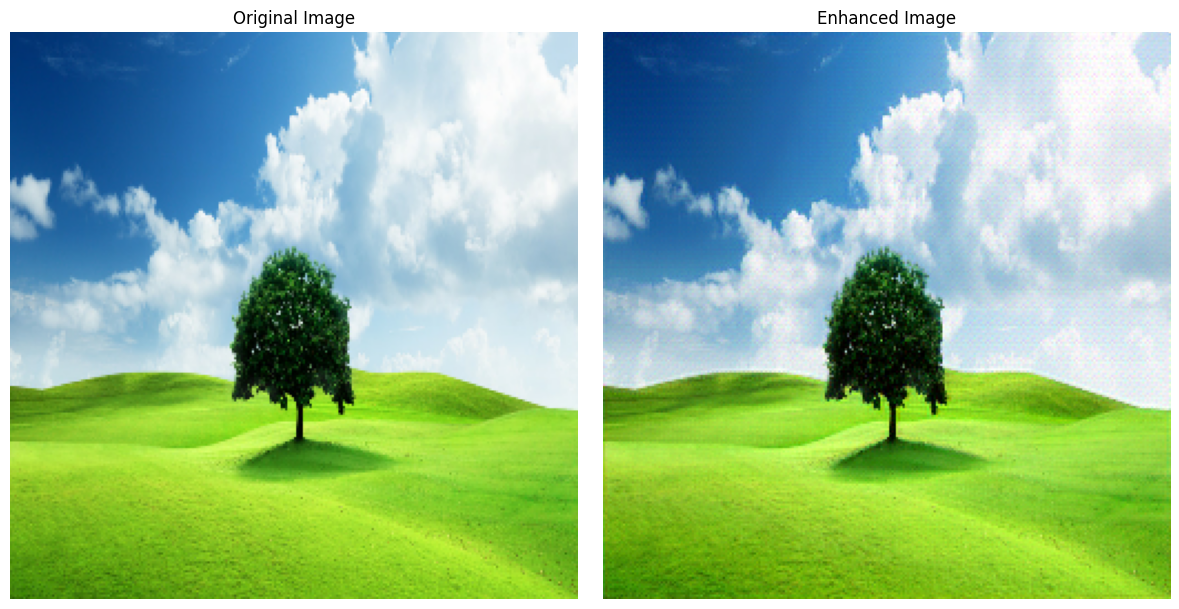

In [29]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    return img

# Load and process the input image
input_image_path = "/content/nature.jpg"  # Update this path to match your image file name
input_image = load_and_preprocess_image(input_image_path)
input_image = normalize(input_image)
input_image = tf.expand_dims(input_image, 0)

# Generate the enhanced image
enhanced_image = generator(input_image, training=False)

# Convert images back to displayable format
input_display = tf.clip_by_value(denormalize(input_image[0]), 0, 255).numpy().astype(np.uint8)
enhanced_display = tf.clip_by_value(denormalize(enhanced_image[0]), 0, 255).numpy().astype(np.uint8)

# Display both the original and enhanced images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_display)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_display)
plt.title('Enhanced Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the enhanced image
plt.imsave('enhanced_image.png', enhanced_display)